<a href="https://colab.research.google.com/github/sjalilian/repositorytest/blob/main/everything-finetunning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
!pip install -q tensorflow
!pip install -q gymnasium

In [25]:
import gymnasium as gym
import numpy as np
import random
import tensorflow as tf
import sys
from datetime import datetime
from io import StringIO
import csv

In [26]:
def softmax(preds, temp):
    probs = preds / temp
    z = probs - probs.max()
    return np.exp(z) / np.sum(np.exp(z))


def argmax(preds):
    try:
        return np.random.choice(np.where(preds == np.max(preds))[0])
    except:
        return np.argmax(preds)


class Logger():
  def __init__(self, agent, filename, session_name=None):
    self.filename = filename
    if not session_name:
      self.session_name = datetime.now().strftime('%Y%m%d_%H%M%S')
    self.agent = agent
    # str_buffer = StringIO()
    # agent.Q.summary(print_fn=lambda x: str_buffer.write(x + '\n'))
    # self.model_summary = str_buffer.getvalue()

  def log(self, epoch, score):
    with open(self.filename, 'a') as outfile:
      writer = csv.writer(outfile)
      writer.writerow([self.session_name,
                        epoch,
                        score,
                        self.agent.exploration_policy,
                        self.agent.epsilon,
                        self.agent.epsilon_decay_rate,
                        self.agent.learning_rate,
                        self.agent.minibatch_size,
                        # self.model_summary,
                        self.agent.temp])

In [27]:
class Agent:
    def __init__(self, n_states, n_actions, network, n_epochs=50,
                 exploration_policy='egreedy', epsilon=None, temp=None,
                 minibatch_size=32, learning_rate=10e-3,
                 training_frequency=10, update_target_frequency=50, max_timesteps=500,
                 epsilon_decay_rate=0.01, epsilon_min=0.05):
        self.n_states = n_states
        self.n_actions = n_actions
        self.n_epochs = n_epochs
        self.Q = network
        self.Q_t = tf.keras.models.clone_model(network)
        self.memory = []
        self.exploration_policy = exploration_policy
        self.epsilon = epsilon
        self.temp = temp
        self.minibatch_size = minibatch_size
        self.learning_rate = learning_rate
        self.training_frequency = training_frequency
        self.update_target_frequency = update_target_frequency
        self.max_timesteps = max_timesteps
        self.steps_since_last_target_update = 0
        self.epsilon_decay_rate = epsilon_decay_rate
        self.epsilon_min = epsilon_min

    def select_action(self, observation):

        observation = np.array(observation).reshape(1, -1)  # '-1' lets numpy determine the size of that dimension
        preds = self.Q_t.predict(observation, verbose=0)
        if self.exploration_policy == 'greedy':
            a = np.argmax(preds)
        elif self.exploration_policy == 'egreedy':
            if self.epsilon is None:
                raise KeyError("Provide an epsilon")
            probs = np.zeros(self.n_actions)
            probs += self.epsilon
            probs /= self.n_actions
            probs[np.argmax(preds)] = 1.0 - self.epsilon + (self.epsilon / self.n_actions)
            a = np.random.choice(np.arange(self.n_actions), p=probs)

            if self.epsilon * (1 - self.epsilon_decay_rate) >= self.epsilon_min:
              self.epsilon *= (1 - self.epsilon_decay_rate)
        elif self.exploration_policy == 'softmax':
            if self.temp is None:
                raise KeyError("Provide a temperature")
            probs = softmax(preds, self.temp)
            a = np.random.choice(np.arange(self.n_actions), p=probs)
        return a

    def push_to_memory(self, obs, a, reward, obs_next, done):
        self.memory.append([obs, a, reward, obs_next, done])

    def sample_minibatch(self):
        if len(self.memory) < self.minibatch_size:
            print('Not enough experiences in the replay buffer.')
            print(f'No experiences: {len(self.memory)}.\tMinibatch size: {self.minibatch_size}')
            sys.exit(1)
        return random.sample(self.memory, self.minibatch_size)

    def replay(self):
        minibatch = self.sample_minibatch()
        for transition in minibatch:
            obs, a, reward, obs_next, done = transition
            obs = obs[np.newaxis]
            obs_next = obs_next[np.newaxis]
            y_hat = reward
            if not done:
                y_hat += self.learning_rate * np.max(self.Q_t.predict(obs_next, verbose=0))
            y_f = self.Q.predict(obs, verbose=0)
            y_f[0][a] = y_hat
            self.Q.fit(obs, y_f, epochs=1, verbose=0)

    def train(self, env):
        logger = Logger(self, 'results.csv')
        for epoch in range(self.n_epochs):
            obs, _ = env.reset()
            obs = np.array(obs)
            print(obs.shape)
            for t in range(self.max_timesteps):
                a = self.select_action(obs)
                obs_next, reward, done, _truncated, _info = env.step(a)
                obs_next = np.array(obs_next)
                self.push_to_memory(obs, a, reward, obs_next, done)
                obs = obs_next
                if t % self.training_frequency == 0 and len(self.memory) >= self.minibatch_size:
                   self.replay()
                self.steps_since_last_target_update += 1
                if self.steps_since_last_target_update >= self.update_target_frequency:
                   self.update_target_network()
                   self.steps_since_last_target_update = 0
                if done:
                  logger.log(epoch, t)
                  print(f"Game: {epoch}/{self.n_epochs}, Score: {t}")
                  break

    def update_target_network(self):
        self.Q_t.set_weights(self.Q.get_weights())

In [28]:
def main():
    state_size = 4
    action_size = 2
    lr = 0.001
    exploration = 'egreedy'
    epsilon = 0.5

    env = gym.make('CartPole-v1')

    network = tf.keras.models.Sequential()
    network.add(tf.keras.layers.Dense(32, input_dim=state_size, activation='relu'))
    network.add(tf.keras.layers.Dense(32, activation='relu'))
    network.add(tf.keras.layers.Dense(action_size, activation='linear'))
    network.compile(loss='mse', optimizer=tf.keras.optimizers.Adam(learning_rate=lr))

    agent = Agent(state_size, action_size, network, learning_rate=lr,
                  exploration_policy=exploration, epsilon=epsilon)
    agent.train(env)

if __name__ == '__main__':
    main()

(4,)
Game: 0/50, Score: 16
(4,)
Game: 1/50, Score: 9
(4,)
Game: 2/50, Score: 9
(4,)
Game: 3/50, Score: 12
(4,)
Game: 4/50, Score: 10
(4,)
Game: 5/50, Score: 11
(4,)
Game: 6/50, Score: 11
(4,)
Game: 7/50, Score: 12
(4,)
Game: 8/50, Score: 11
(4,)
Game: 9/50, Score: 10
(4,)
Game: 10/50, Score: 14
(4,)
Game: 11/50, Score: 11
(4,)
Game: 12/50, Score: 11
(4,)
Game: 13/50, Score: 11
(4,)
Game: 14/50, Score: 12
(4,)
Game: 15/50, Score: 9
(4,)
Game: 16/50, Score: 9
(4,)
Game: 17/50, Score: 8
(4,)
Game: 18/50, Score: 8
(4,)
Game: 19/50, Score: 9
(4,)
Game: 20/50, Score: 10
(4,)
Game: 21/50, Score: 11
(4,)
Game: 22/50, Score: 9
(4,)
Game: 23/50, Score: 12
(4,)
Game: 24/50, Score: 20
(4,)
Game: 25/50, Score: 33
(4,)
Game: 26/50, Score: 32
(4,)
Game: 27/50, Score: 32
(4,)
Game: 28/50, Score: 9
(4,)
Game: 29/50, Score: 7
(4,)
Game: 30/50, Score: 10
(4,)
Game: 31/50, Score: 8
(4,)
Game: 32/50, Score: 9
(4,)
Game: 33/50, Score: 10
(4,)
Game: 34/50, Score: 9
(4,)
Game: 35/50, Score: 11
(4,)
Game: 36/5

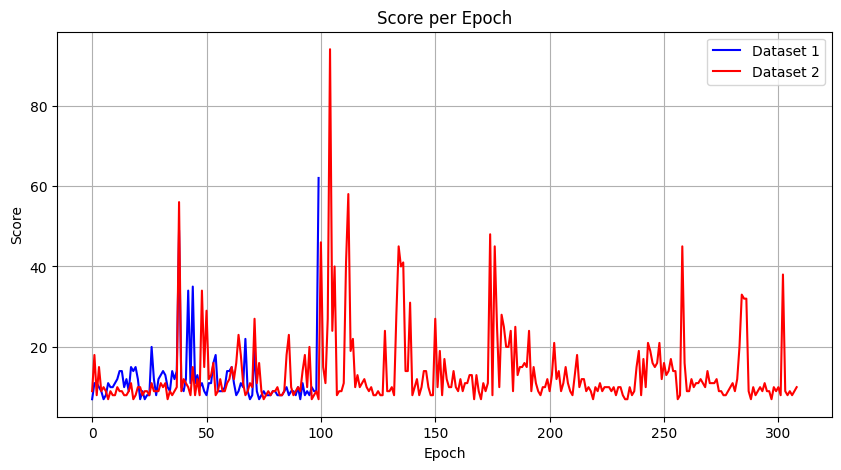

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the first dataset from the CSV file
data1 = pd.read_csv('results3.csv', header=None) #with 100 ephoch
data1.dropna(how='all', inplace=True)

# Load the second dataset from another CSV file
data2 = pd.read_csv('results.csv', header=None) #with 50 ephoc
data2.dropna(how='all', inplace=True)

# Plot the scores from the first dataset
plt.figure(figsize=(10,5))
plt.plot(data1[2], label='Dataset 1', color='blue')  # assuming that the score is in the third column
plt.plot(data2[2], label='Dataset 2', color='red')   # assuming that the score is in the third column
plt.title('Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.legend()
plt.grid(True)
plt.show()


 fine tunning hyperparameter



In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
import itertools
import gymnasium as gym
import numpy as np

# Define the grid of hyperparameters to search
learning_rates = [0.001, 0.0001]
epsilon_values = [1.0, 0.1, 0.01]
minibatch_sizes = [32, 64]

# Define a function to create the Q-network
def create_network(state_size, action_size, learning_rate):
    model = Sequential()
    model.add(Dense(32, input_dim=state_size, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(action_size, activation='linear'))
    model.compile(loss='mse', optimizer=Adam(learning_rate=learning_rate))
    return model

# Define a function to evaluate the agent's performance
def evaluate_agent(env, agent, num_episodes=100):
    total_rewards = []
    for _ in range(num_episodes):
        observation, _ = env.reset()  # Adjusted based on your environment's reset() return value
        done = False
        total_reward = 0
        while not done:
            action = agent.select_action(observation)
            result = env.step(action)  # Store the full return tuple in a single variable
            observation, reward, done, info = result[:4]  # Unpack the first four values
            # Log the length and contents of `result` if unexpected values are returned
            if len(result) > 4:
                print(f"Unexpected number of return values from step(): {len(result)}. Values: {result}")
            total_reward += reward
        total_rewards.append(total_reward)
    return np.mean(total_rewards)


# Initialize the environment
env = gym.make('CartPole-v1')

# Perform grid search
best_score = -np.inf
best_params = {}
for lr, epsilon, minibatch_size in itertools.product(learning_rates, epsilon_values, minibatch_sizes):
    print(f"Testing with learning rate: {lr}, epsilon: {epsilon}, minibatch_size: {minibatch_size}")

    # Create and train the agent with the current set of hyperparameters
    agent = Agent(n_states=env.observation_space.shape[0],
                  n_actions=env.action_space.n,
                  network=create_network(env.observation_space.shape[0], env.action_space.n, lr),
                  exploration_policy='egreedy', epsilon=epsilon, minibatch_size=minibatch_size,
                  learning_rate=lr)
    # Assume there is a train function in Agent that trains for a fixed number of epochs
    agent.train(env)

    # Evaluate the trained agent
    score = evaluate_agent(env, agent)
    print(f"Average reward: {score}")

    # Update the best score and parameters
    if score > best_score:
        best_score = score
        best_params = {'learning_rate': lr, 'epsilon': epsilon, 'minibatch_size': minibatch_size}

# Print the best set of hyperparameters
print(f"Best hyperparameters: {best_params} with average reward: {best_score}")


Streaming output truncated to the last 5000 lines.
Unexpected number of return values from step(): 5. Values: (array([ 1.1468138e-04,  5.7601500e-01, -1.6720271e-02, -8.9066988e-01],
      dtype=float32), 1.0, False, False, {})
Unexpected number of return values from step(): 5. Values: (array([ 0.01163498,  0.77135974, -0.03453367, -1.1885617 ], dtype=float32), 1.0, False, False, {})
Unexpected number of return values from step(): 5. Values: (array([ 0.02706218,  0.57670206, -0.0583049 , -0.90690005], dtype=float32), 1.0, False, False, {})
Unexpected number of return values from step(): 5. Values: (array([ 0.03859622,  0.77256286, -0.0764429 , -1.217324  ], dtype=float32), 1.0, False, False, {})
Unexpected number of return values from step(): 5. Values: (array([ 0.05404748,  0.5785054 , -0.10078938, -0.94954014], dtype=float32), 1.0, False, False, {})
Unexpected number of return values from step(): 5. Values: (array([ 0.06561758,  0.7748291 , -0.11978018, -1.2721131 ], dtype=float32), 